In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
import json
from IPython.display import display
from ipyfilechooser import FileChooser
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from scipy.stats import zscore
from scipy.interpolate import interp1d
from itertools import groupby
import sys 
import pickle

from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

%matplotlib widget

In [2]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
except:
    print("the path was not defined in store")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"


# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Select session folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

Stored 'dpath' (str)
Stored 'dpath' (str)


In [68]:
from scipy.signal import butter, filtfilt, hilbert

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs  # Nyquist Frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def get_filt_env(lfp_signal, lowcut, highcut, fs):
    filtered_signal = bandpass_filter(lfp_signal, lowcut, highcut, fs)
    analytic_signal = hilbert(filtered_signal)
    envelope = np.abs(analytic_signal)
    window_size = fs*5 #5 sec
    smoothed_envelope = moving_average(envelope, window_size)
    return smoothed_envelope

In [72]:
Channels = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/LFPChannels_perMice.xlsx' 
allchannels = pd.read_excel(Channels)

folder_base = Path(os.path.join(dpath, "OpenEphys"))
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
All = np.load(filename2, mmap_mode= 'r')

path_obj=Path(folder_base.parent)
if len(path_obj.parts)==10: # Not a DrugExperiment with Subsessions       
    mice= path_obj.parents[1].name
elif len(path_obj.parts)==9: # Not a DrugExperiment with No Subsessions
    mice= path_obj.parents[0].name
elif len(path_obj.parts)==11: # DrugExperiment with Subsessions
    mice = path_obj.parents[2].name


CA1ch1=int(allchannels[mice][2].split(',')[0])
CA1ch2=int(allchannels[mice][2].split(',')[1])
CA1  =  All[:, CA1ch1]-All[:, CA1ch2] 

PFCch1=int(allchannels[mice][0].split(',')[0])
PFCch2=int(allchannels[mice][0].split(',')[1])
PFC  =  All[:, PFCch1]-All[:, PFCch2] 

S1ch1=int(allchannels[mice][1].split(',')[0])
S1ch2=int(allchannels[mice][1].split(',')[1])
S1  =  All[:, S1ch1]-All[:, S1ch2] 

ThetaCh = CA1
Beta1Ch = PFC
Beta2Ch = S1

EMGch=int(allchannels[mice][3])
EMG  =  All[:, EMGch]

SigmaPFC=get_filt_env(PFC, 10, 16, 1000)
SigmaS1=get_filt_env(S1, 10, 16, 1000)
ThetaCA1=get_filt_env(CA1, 5, 9, 1000)
DeltaS1=get_filt_env(S1, 1, 4, 1000)   
DeltaPFC=get_filt_env(PFC, 1, 4, 1000)   
EMGf=get_filt_env(EMG, 200, 400, 1000)

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

interpolated_data=pd.Series(SigmaPFC+SigmaS1)
minivigSt=20
smoothed_data_pandas =interpolated_data.rolling(window=1000*minivigSt, center=True).mean()
data_filled_forward = np.copy(smoothed_data_pandas)
nan_indices = np.isnan(data_filled_forward)
data_filled_forward[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), data_filled_forward[~nan_indices])
data_filled_backward = np.copy(data_filled_forward)
nan_indices = np.isnan(data_filled_backward)
data_filled_backward[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), data_filled_backward[~nan_indices], left=np.nan, right=np.nan)
smoothed_data_pandas=data_filled_backward

data=SigmaPFC+SigmaS1
data=np.array(smoothed_data_pandas)
data_reshaped = data.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_reshaped)
labelsSigma = kmeans.labels_
cluster_means = [np.mean(data[labelsSigma == i]) for i in range(2)]
sorted_indices = np.argsort(cluster_means)
cluster_map = {old: new for new, old in enumerate(sorted_indices)}
labelsSigma = np.array([cluster_map[label] for label in labelsSigma])


interpolated_data=pd.Series(ThetaCA1/(DeltaS1))
minivigSt=20
smoothed_data_pandas =interpolated_data.rolling(window=1000*minivigSt, center=True).mean()
data_filled_forward = np.copy(smoothed_data_pandas)
nan_indices = np.isnan(data_filled_forward)
data_filled_forward[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), data_filled_forward[~nan_indices])
data_filled_backward = np.copy(data_filled_forward)
nan_indices = np.isnan(data_filled_backward)
data_filled_backward[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), data_filled_backward[~nan_indices], left=np.nan, right=np.nan)
smoothed_data_pandas=data_filled_backward

data=ThetaCA1/(DeltaS1)
data=np.array(smoothed_data_pandas)
data_reshaped = data.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_reshaped)
labelsThetaDelta = kmeans.labels_
cluster_means = [np.mean(data[labelsThetaDelta == i]) for i in range(2)]
sorted_indices = np.argsort(cluster_means)
cluster_map = {old: new for new, old in enumerate(sorted_indices)}
labelsThetaDelta = np.array([cluster_map[label] for label in labelsThetaDelta])


data=EMGf
data_reshaped = data.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_reshaped)
labelsEMGf = kmeans.labels_
cluster_means = [np.mean(data[labelsEMGf == i]) for i in range(2)]
sorted_indices = np.argsort(cluster_means)
cluster_map = {old: new for new, old in enumerate(sorted_indices)}
labelsEMGf = np.array([cluster_map[label] for label in labelsEMGf])



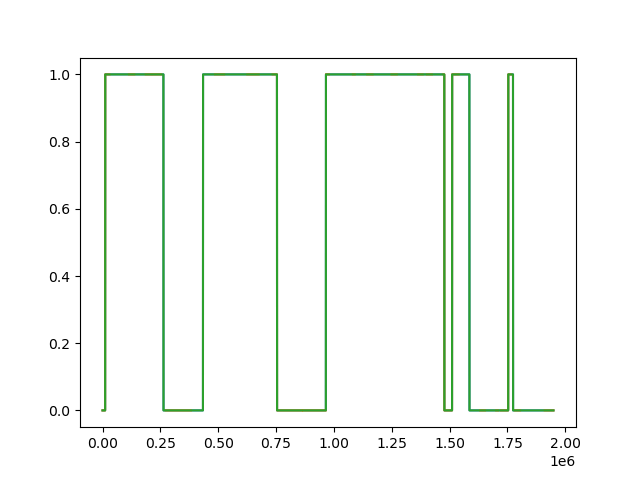

In [73]:
# 0 Wake, 1 NREM, 2REM
ScoringVector = np.full(len(labelsEMGf), np.nan)

for i in range(len(labelsEMGf)): 
    if labelsThetaDelta[i]==1 : #high Thetadelta so Wake 
        ScoringVector[i]=0 #Wake
    elif labelsEMGf[i]==0 and labelsThetaDelta[i]==1 and labelsSigma[i]==0: #atonia so REM
        ScoringVector[i]=2 #REM
    elif labelsSigma[i]==1: #low EMG and high Sigma so NREM
        ScoringVector[i]=1 #NREM
    elif  labelsEMGf[i]<0 :
        ScoringVector[i]=0 #Wake

data = ScoringVector
data_series = pd.Series(data)
interpolated_data = data_series.interpolate(method='nearest')
minivigSt=10
smoothed_data_pandas = np.round(interpolated_data.rolling(window=1000*minivigSt, center=True).mean())

data_filled_forward = np.copy(smoothed_data_pandas)
nan_indices = np.isnan(data_filled_forward)
data_filled_forward[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), data_filled_forward[~nan_indices])
data_filled_backward = np.copy(data_filled_forward)
nan_indices = np.isnan(data_filled_backward)
data_filled_backward[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), data_filled_backward[~nan_indices], left=np.nan, right=np.nan)
NewScoringVector=data_filled_backward

plt.close()
plt.plot(interpolated_data)
plt.plot(ScoringVector)
plt.plot(NewScoringVector)


In [74]:
folder_base = Path(dpath) 
ScoringFile = folder_base / f'OpenEphys/ScoredSleep_AB.npy'
ScoringFile2 = folder_base / f'OpenEphys/ScoredSleep_AH.npy'
SleepScoredTS=np.load(ScoringFile)
SleepScoredTS2=np.load(ScoringFile2)

# Upscale Scoring
indices = np.linspace(0, len(SleepScoredTS) - 1, len(SleepScoredTS))
new_indices = np.linspace(0, len(SleepScoredTS) - 1, len(EMG))
interpolated_func = interp1d(indices, SleepScoredTS, kind='previous')
SleepScoredTS_upscaled = interpolated_func(new_indices)
SleepScoredTS_upscaled = np.round(SleepScoredTS_upscaled * 2) / 2

# Upscale Scoring
indices = np.linspace(0, len(SleepScoredTS2) - 1, len(SleepScoredTS2))
new_indices = np.linspace(0, len(SleepScoredTS2) - 1, len(EMG))
interpolated_func = interp1d(indices, SleepScoredTS2, kind='previous')
SleepScoredTS_upscaled2 = interpolated_func(new_indices)
SleepScoredTS_upscaled2 = np.round(SleepScoredTS_upscaled2 * 2) / 2


In [75]:
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, CsvEpochSource, EpochEncoder,EpochViewer
from ephyviewer import InMemoryAnalogSignalSource

app = mkQApp()
freqLFP=1000
sample_rate = freqLFP
t_start = 0.

combined = np.stack([(S1), (PFC), (CA1)/5, (EMG)/5], axis = 1)

#create 2 familly scatters from theses 2 indexes
#and asign them to some channels each
scatter_channels = {0: [1], 1: [1], 2: [0], 3: [0], 4: [2], 5: [2]}

#mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
#source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#222222', 2: '#FFFFFF', 3: '#222222', 4: '#FFFFFF', 5: '#222222'}, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])

#Create the main window that can contain several viewers
#win = MainViewer(debug=True, show_auto_scale=True)
win = MainViewer()

view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals')
#view1 = TraceViewer(source=source)

#Parameters can be set in script
view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True

view1.params['scale_mode'] = 'same_for_all'
view1.auto_scale()

#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#88FF88' #FF0000 red, #00FF00 green, and #0000FF blue
view1.by_channel_params['ch1', 'color'] = '#8888FF'
view1.by_channel_params['ch2', 'color'] = '#FF8888'
view1.by_channel_params['ch3', 'color'] = '#FFFFFF'

array=SleepScoredTS_upscaled
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_duration =np.array(substates_duration)/freqLFP
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()
substates_start =np.append([0],substates_end[:-1])
mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
substates_identity = [mapp[num] for num in substates_identity]
substates_identity = np.array(substates_identity)

all_epochs = []
ep_times=[]
ep_durations=[]
ep_labels=[]

states=['NREM', 'N2', 'REM', 'Wake']
for c,st in enumerate(states):
    ep_times=[]
    ep_durations=[]
    ep_labels=[]
    for subs in range(len(substates_duration)):
        if substates_identity[subs] == st:
            ep_times.append(substates_start[subs])
            ep_durations.append(substates_duration[subs])
            ep_labels.append(subs)
    all_epochs.append({ 'time':np.array(ep_times), 'duration':np.array(ep_durations), 'label':np.array(ep_labels), 'name':st })

source_ep = ephyviewer.InMemoryEpochSource(all_epochs=all_epochs)
view2= EpochViewer(source=source_ep, name='Scoring AB')

view2.by_channel_params['ch0', 'color'] = '#5555FF'
view2.by_channel_params['ch1', 'color'] = '#AA00FF'
view2.by_channel_params['ch2', 'color'] = '#00AA00'
view2.by_channel_params['ch3', 'color'] = '#FFFFFF'


array=NewScoringVector
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_duration =np.array(substates_duration)/freqLFP
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()
substates_start =np.append([0],substates_end[:-1])
mapp = {0: 'Wake', 1: 'NREM', 2: 'REM'}
substates_identity = [mapp[num] for num in substates_identity]
substates_identity = np.array(substates_identity)

all_epochs = []
ep_times=[]
ep_durations=[]
ep_labels=[]

states=['NREM', 'N2', 'REM', 'Wake']
for c,st in enumerate(states):
    ep_times=[]
    ep_durations=[]
    ep_labels=[]
    for subs in range(len(substates_duration)):
        if substates_identity[subs] == st:
            ep_times.append(substates_start[subs])
            ep_durations.append(substates_duration[subs])
            ep_labels.append(subs)
    all_epochs.append({ 'time':np.array(ep_times), 'duration':np.array(ep_durations), 'label':np.array(ep_labels), 'name':st })

source_ep2 = ephyviewer.InMemoryEpochSource(all_epochs=all_epochs)
view4= EpochViewer(source=source_ep2, name='Scoring AH')

view4.by_channel_params['ch0', 'color'] = '#5555FF'
view4.by_channel_params['ch1', 'color'] = '#AA00FF'
view4.by_channel_params['ch2', 'color'] = '#00AA00'
view4.by_channel_params['ch3', 'color'] = '#FFFFFF'


#add them to mainwindow
win.add_view(view1)
win.add_view(view2)
win.add_view(view4)

#Run
win.show()
app.exec_()

0